In [8]:
import glob
import os 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 

In [9]:
from astropy.io import fits
import astropy.wcs as wcs

hdul = fits.open("/Users/alexgagliano/Documents/Research/2020oi/data/SN2020oi_MUSE_2D_vrad_star_platesolved.fits")

In [68]:
#hdul[0].data
w = wcs.WCS(hdul[0].header, hdul)
center_ra = 185.7289250    
center_dec = 15.8223250

shock_ra_arm1 = 185.7290333    
shock_dec_arm1 = 15.8210889  

ra_20oi = 185.728875
dec_20oi = 15.8236

shock_ra_arm2 = 185.7281500    
shock_dec_arm2 = 15.8232806

ra = np.array([shock_ra_arm1, ra_20oi, center_ra, shock_ra_arm2])
dec = np.array([shock_dec_arm1, dec_20oi, center_dec, shock_dec_arm2])

x, y = w.all_world2pix(ra, dec, 1)

x = x.astype(int)
y = y.astype(int)

In [69]:
data = hdul[0].data

In [70]:
from astropy import units as u
from astropy.coordinates import SkyCoord
coord_shock = SkyCoord(ra[0]*u.deg, dec[0]*u.deg, frame='icrs')
coord_20oi = SkyCoord(ra[1]*u.deg, dec[1]*u.deg, frame='icrs')
coord_center = SkyCoord(ra[2]*u.deg, dec[2]*u.deg, frame='icrs')
coord_shock2 = SkyCoord(ra[3]*u.deg, dec[3]*u.deg, frame='icrs')

sep = coord_shock.separation(coord_20oi)

In [71]:
print(coord_shock2.separation(coord_center))
print(coord_shock.separation(coord_center))
print(coord_20oi.separation(coord_center))

0d00m04.3635s
0d00m04.4657s
0d00m04.5933s


In [72]:
center_distance = (4.3635)/206265 * 1.71e7

In [73]:
print("Distance to center is %.2f kpc."% (center_distance/1.e3))

Distance to center is 0.36 kpc.


In [74]:
# (which is inside the corotation radius)
# pattern speed - estimate 55km/s/kpc from On the relevance of the Tremaine-Weinberg method applied to H-alpha velocity field.Pattern speeds determination in M100 (NGC 4321)
# https://arxiv.org/abs/astro-ph/0505384
# At an inner resonance, a star's orbital speed is increased, moving the star outwards, and decreased for an outer resonance causing inward movement. 

In [75]:
pattern_speed = 55 * 0.36 # the spiral arm speed at the location of 2020oi, in km/s

In [105]:
#vel_high = 164.7 # km/s, approximate from digitizing https://iopscience.iop.org/article/10.1086/308162/fulltext/
vel_high = 100. #an estimate on the uncertainty of the rotation curve from Halphas
vel_low = 80. #an estimate on the uncertainty of the rotation curve from Halphas

In [106]:
rel_speed_high = vel_high - pattern_speed
rel_speed_low = vel_low - pattern_speed

In [107]:
#first, let's get the angle subtended between the two points
d = 17.1 #Mpc
dist_btw_points = coord_shock.separation(coord_20oi).arcsec*d/206265 #separation in Mpc
dist_btw_points2 = coord_shock2.separation(coord_20oi).arcsec*d/206265 #separation in Mpc
dist_to_center = coord_20oi.separation(coord_center).arcsec*d/206265 #distance to center in Mpc
dist_to_center2 = coord_shock2.separation(coord_center).arcsec*d/206265 #distance to center in Mpc
#two sides of the isosceles triangle, split it in half to get a right triangle
base_right = dist_btw_points/2.
base_right2 = dist_btw_points2/2.
hyp_right = dist_to_center
hyp_right2 = dist_to_center2
angle = 2*np.degrees(np.arcsin(base_right/hyp_right))
angle2 = 2*np.degrees(np.arcsin(base_right2/hyp_right2))
#go the other way - the star is moving past the spiral arm!
angle = 360 - angle
angle = np.array([angle, angle+360])
angle2 = np.array([angle2, angle2+360])
L = angle*np.pi*dist_to_center/180. #in Mpc
L2 = angle2*np.pi*dist_to_center2/180. #in Mpc

In [108]:
#phys_sep = sep.arcsec*d/206265 #angular to physical separation
sep_pc2 = (L2*1.e6)*3.086e+13 #Mpc to pc to km, with the rough distance of the stellar cluster added on
sep_pc1 = (L*1.e6)*3.086e+13 #Mpc to pc to km, with the rough distance of the stellar cluster added on

In [109]:
d = 17.1 #Mpc
sep_pc1 /= np.cos(np.pi/6) #correct for tilt of the galaxy, i=30 degrees from https://iopscience.iop.org/article/10.1086/308162/fulltext/
time_s_low1 = sep_pc1/rel_speed_high
time_s_high1 = sep_pc1/rel_speed_low

In [110]:
sep_pc2 /= np.cos(np.pi/6) #correct for tilt of the galaxy, i=30 degrees from https://iopscience.iop.org/article/10.1086/308162/fulltext/
time_s_low2 = sep_pc2/rel_speed_high
time_s_high2 = sep_pc2/rel_speed_low

In [111]:
time_logyr_low1 = np.log10(time_s_low1/3.154e+7)
time_logyr_high1 = np.log10(time_s_high1/3.154e+7)
time_logyr_avg1 = np.mean([time_logyr_low1, time_logyr_high1], axis=0)
oneSig1 = (time_logyr_high1 - time_logyr_low1)/2.

time_logyr_low2 = np.log10(time_s_low2/3.154e+7)
time_logyr_high2 = np.log10(time_s_high2/3.154e+7)
time_logyr_avg2 = np.mean([time_logyr_low2, time_logyr_high2], axis=0)
oneSig2 = (time_logyr_high2 - time_logyr_low2)/2.

In [112]:
for i in np.arange(len(oneSig1)):
    print(r"Best estimate from Arm 1, rotation %i is log10(Age) = %.2f +/- %.2f years, or %.2f Myr." % (i+1, np.round(time_logyr_avg2[i], 2), np.round(oneSig2[i], 2), np.round(10**time_logyr_avg2[i], 2)/1.e6))
    print(r"Best estimate from Arm 2, rotation %i is log10(Age) = %.2f +/- %.2f years, or %.2f Myr." % (i+1, np.round(time_logyr_avg1[i], 2), np.round(oneSig1[i], 2), np.round(10**time_logyr_avg1[i], 2)/1.e6))

Best estimate from Arm 1, rotation 1 is log10(Age) = 6.58 +/- 0.06 years, or 3.79 Myr.
Best estimate from Arm 2, rotation 1 is log10(Age) = 7.33 +/- 0.06 years, or 21.54 Myr.
Best estimate from Arm 1, rotation 2 is log10(Age) = 7.61 +/- 0.06 years, or 40.75 Myr.
Best estimate from Arm 2, rotation 2 is log10(Age) = 7.78 +/- 0.06 years, or 60.44 Myr.


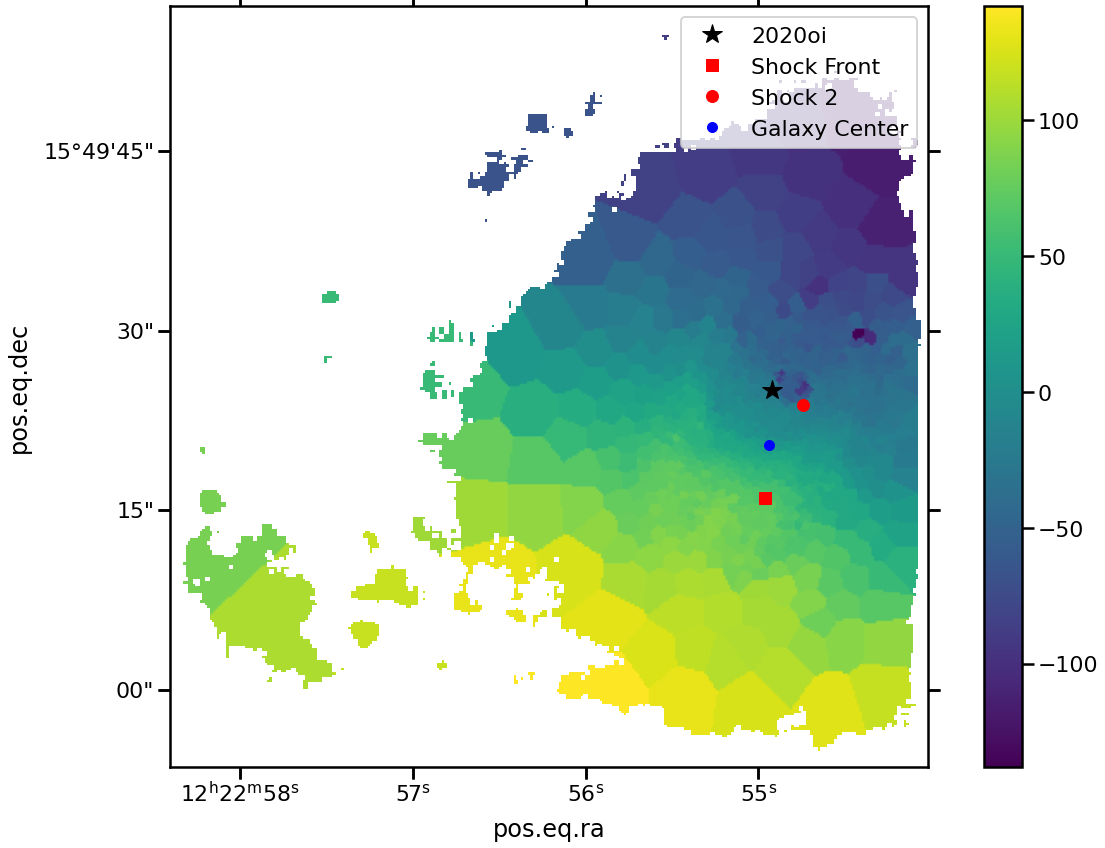

In [43]:
#Best estimate from rotation argument is log10(Age) = 7.28 +/- 0.13 years, or 19.04 Myr.
#Best estimate from rotation argument is log10(Age) = 7.09 +/- 0.13 years, or 12.41 Myr.
sns.set_context("poster")
plt.figure(figsize=(20,14))

plt.subplot(projection=w)
plt.imshow(data)
plt.plot(x[1],y[1], '*', ms=20, c='k', label='2020oi')
plt.plot(x[0], y[0], 's', ms=12, c='r', label='Shock Front')
plt.plot(x[3], y[3], 'o', ms=12, c='r', label='Shock 2')
plt.plot(x[2], y[2], '.', ms=20, c='b', label='Galaxy Center')
plt.colorbar()
plt.legend()

In [ ]:
#corotation radius for this is 